# <center> 🤿 Погружение в Агентов LangChain  </center>
### <center> 😎 Создаём "суперагента" 🕵️‍♂️ </center>

### Оглавление ноутбука
<img src='../images/LangChain_Agent.png' align="right" width="500" height="528" style="border-radius: 0.75rem;">

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#p1">🤖 Основные типы агентов и их суперспособности 🦾</a></li>
<li><a href="#p1">🗣🕶 Tool calling Agent - базовый агент!</a></li>
<li><a href="#p5">😎 Агент, который всё помнит! 🫣</a></li>
<li><a href="#p2">🚀 ReAct Agent, который думает 🔄</a></li><ul type="square">
<li><a href="#p2.1">🔎 Инструмент поиск Google (SerpAPI) 🔎</a></li></ul>
<li><a href="#p3">💬 Structured Chat Agent правильно вызывает tools💬</a></li>
<li><a href="#p4">🙋🏻 Self-Ask with search Agent, который рассуждает❓</a></li>
<li><a href="#p6">🪛 Agent + RAG 🦞</a></li>
<li><a href="#p7">🙋🏻 Agent с sql базой 📊</a></li><ul type="square">
<li><a href="#p7.1"> 🫂 SQL агент + python агент = super агент 😎</a></li></ul>
<li><a href="#p8">Задеплой Агента с помощью LangServe 🛋 </a></li>
<li><a href="#p9">🥁 Выводы и заключения ✅ </a></li>    
</ul></font></p>

### 🧑‍🎓 В этом уроке более подробно погрузимся в возможности агентов с LangChain.


<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

<img src='../images/agent_tool_seqs.jpg' align="right" width="600" height="528" style="border-radius: 0.75rem;">


В прошлом модуле курса мы разобрались с инструментами (`tools`) для моделей, и тем как их можно вызывать (`tools calling`). Неудобство было в том, что мы не могли сразу воспользоваться результатом вызова инструмента для получения финального ответа.


</div>

📖 Здесь нам на помощь приходит концепция **агентов**, специальный вид `Runnables` в `LangChain`, который может:

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

* Составлять план действий для решения задачи
* Использовать необходимое количество инструментов 
* Определять последовательность использования инструментов и с какими параметрами их вызывать (!)
* Повторять операции несколько раз до получения ответа

- из минусов можно отметить использование большого количества токенов для работы.

# <center  id="p1"> 🤖 Основные типы агентов и их суперспособности 🦾 </center>

<div class="alert alert-info">
    
📖 Основные концепции агентов в `LangChain`:
* `Tool_Calling_Agent` - базовый тип агента, который можно кастомизировать собственными промптами.
* `ReAct (Reasoning and Acting)` - агенты составляющие план и работающие по циклу, пока не добьются результата. Работают с инструментами, принимающими один параметр на вход.
* `Structured chat` - могут работать с инструментами, которые принимают много параметров на вход
* `Self Ask with Search` - реализация техники промптинга `Self-Ask`, работает только с инструментами поиска
* `XMLAgent, JSONAgent` - для работы с чат моделями в форматах `XML` и `JSON` (например, модели от `Anthropic`)
* `OpenAI Tools Agents` - могут вызывать сразу один или несколько инструментов в запросе, тем самым сокращая время для получения ответа - работает с последними моделями от `OpenAI`.

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Разберем подробнее первые 4 типа. Каждый агент "под капотом" содержит свой промпт, завернутый в удобную обертку агента `LangChain`.

### 🤖 Готовим LLM к бою 🤺

In [1]:
!pip install langchain==0.3.27 langchain_community langchain-openai openai langchainhub google-search-results numexpr faiss-cpu langchain-experimental langserve[all] -q -U

In [6]:
import os
from getpass import getpass

In [3]:
# Для работы в колабе загрузите необходимые файлы!
# !mkdir ../data/
# !wget -P ../data https://raw.githubusercontent.com/a-milenkin/LLM_practical_course/main/data/pizzeria.db

In [5]:
# Если используете ключ от OpenAI, запустите эту ячейку
from langchain_openai import ChatOpenAI

# os.environ['OPENAI_API_KEY'] = "Введите ваш OpenAI API ключ"
os.environ['OPENAI_API_KEY'] = getpass(prompt='Введите ваш OpenAI API ключ')

# инициализируем языковую модель
llm = ChatOpenAI(temperature=0.0)

In [15]:
# Если используете ключ из курса, запустите эту ячейку
from langchain_openai import ChatOpenAI

# course_api_key= "Введите ваш ключ, полученный в боте курса"
course_api_key = getpass(prompt="Введите ваш ключ, полученный в боте курса:")

# инициализируем языковую модель
llm = ChatOpenAI(api_key=course_api_key, model='gpt-4o-mini', 
                 base_url="https://api.vsellm.ru/")

Введите ваш ключ, полученный в боте курса: ········


# <center  id="p1"> 🗣🕶 `Tool calling Agent` - базовый агент!</center>


Для начала разберёмся с самым простым агентом и его составными частями!

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
📖 Для создания агента нам понадобятся:
- специально составленный промпт
- инструменты
- модель
- специальные методы и классы из `LangChain` для создания агента.

In [16]:
# Загрузим уже знакомые нам инструменты
from langchain.agents import load_tools, tool

tools = load_tools(["llm-math"], llm=llm)

@tool
def get_word_length(word: str) -> int:
    """Возвращает длину слова""" # добавляем docstring
    return len(word)


tools.append(get_word_length)
len(tools)

2

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Теперь составим промпт, основное его отличие - это наличие обязательного ключа `agent_scratchpad`, в котором будут храниться все промежуточные шаги агента и результаты вызова инструментов агентом.

In [9]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Ты полезный ассистент"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"), # <--- новый элемент !
    ]
)

prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='Ты полезный ассистент'), additional_kwargs={}),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={}),
 MessagesPlaceholder(variable_name='agent_scratchpad', optional=True)]

In [17]:
# создаём агента, передадим модель, инструменты и промпт
from langchain.agents import AgentExecutor, create_tool_calling_agent

agent = create_tool_calling_agent(llm, tools, prompt)

In [18]:
# Для запуска агента используется класс AgentExecutor
agent_executor = AgentExecutor(
    agent=agent, 
    tools=tools,
    max_iterations=5, # максимальное количество итераций агента (15 по умолчанию) 
    handle_parsing_errors = True, # Агент не упадёт с ошибкой, если не распарсит ответ
    verbose=True # показывать промежуточные шаги агента или сразу выводить ответ
                              )

# так как это Runnable используем invoke
agent_executor.invoke({"input": "Сколько букв в слове зачёт?"})



> Entering new AgentExecutor chain...

Invoking: `get_word_length` with `{'word': 'зачёт'}`


5В слове "зачёт" 5 букв.

> Finished chain.


{'input': 'Сколько букв в слове зачёт?', 'output': 'В слове "зачёт" 5 букв.'}

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Видим рассуждения агента - он вызвал инструмент `get_word_length` с аргументом `{'word': 'зачёт'}` и сразу использовал результат для окончательного ответа.

# <center id="p5"> 😎 Агент, который всё помнит! 🫣 </center>
    
#### <center> Как добавить агенту память? 🧠</center>

<div class="alert alert-info">

Тут такой же механизм, как и с добавлением памяти к любому `Runnable`.

In [12]:
# Добавляем в промпт ещё один ключ chat-history
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Ты полезный ассистент"),
        ("placeholder", "{chat_history}"), # <-- история диалога
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

In [13]:
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

# Создадим словарь, который будет мапить session_id с историей диалога этой сессии
store = {}

# Напишем функцию, которая возвращает историю диалога по session ID.
def get_session_history(session_id: str) -> InMemoryChatMessageHistory:
    if session_id not in store:
        store[session_id] = InMemoryChatMessageHistory()
    return store[session_id]

In [14]:
agent_with_history = RunnableWithMessageHistory(
    agent_executor,
    get_session_history,
    input_messages_key="input",  # указываем название переменой запроса
    history_messages_key="chat_history", # название переменной для истории из шаблона
)

agent_with_history.invoke({"input": "Сколько букв в слове зачёт?"},
                            config={"configurable": {"session_id": "1"}})



> Entering new AgentExecutor chain...

Invoking: `get_word_length` with `{'word': 'зачёт'}`


5В слове "зачёт" 5 букв.

> Finished chain.


{'input': 'Сколько букв в слове зачёт?',
 'chat_history': [],
 'output': 'В слове "зачёт" 5 букв.'}

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
✅ Видим, что в ответе появился ключ `chat_history`, но он пока пустой. 

In [15]:
agent_with_history.invoke({"input": "А в слове ёж?"},
                            config={"configurable": {"session_id": "1"}})



> Entering new AgentExecutor chain...

Invoking: `get_word_length` with `{'word': 'ёж'}`


2В слове "ёж" 2 буквы.

> Finished chain.


{'input': 'А в слове ёж?',
 'chat_history': [HumanMessage(content='Сколько букв в слове зачёт?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='В слове "зачёт" 5 букв.', additional_kwargs={}, response_metadata={})],
 'output': 'В слове "ёж" 2 буквы.'}

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
✅ По истории диалога агент понял, что мы хотим посчитать количество букв в новом слове. <br>
А в `chat_history` появилась запись с предыдущим диалогом.

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Рассмотренный тип агента даёт большие возможности для кастомизации за счёт промптинга, но в базовом варианте использования не сможет справится со сложными задачами. Для решения более сложных задач, в `Langchain` предусмотрены несколько других.

# <center  id="p2"> `ReAct` `Agent` - сначала придумай план, потом делай!🚀</center>

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

<img src='../images/react_sch.png' align="right" width="550" height="428" style="border-radius: 0.75rem;">

📖 Этот тип агента реализуется на основе техники `ReAct Prompting` представленной командой GoogleResearch в 2022 году в статье [ReAct: Synergizing Reasoning and Acting in Language Models](https://arxiv.org/abs/2210.03629).



**`ReAct`** объединила в себе два подхода:
* **`Reasoning`** (техника Chain of Thoughts)
* **`Acting`** (Action Plan Generation - генерация плана действий)


<div style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

    
#### Посмотрим как выглядит шаблон промпта ReAct агента в `LangChain`:

```
Answer the following questions as best you can. You have access to the
following tools:
{tools}
Use the following format:
Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question
Begin!
Question: {input}
Thought:{agent_scratchpad}
```

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

Шаблоны промптов, используемые в агентах (и не только) хранятся в [LangChain Hub](https://smith.langchain.com/hub). Туда, примерно так же, как на `GitHub`, можно загружать свои промпты и потом удобно ими пользоваться. 🤗

In [19]:
from langchain import hub

prompt = hub.pull("hwchase17/react")
print(prompt)

/home/jovyan/venvs/sinara/lib/python3.10/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


input_variables=['agent_scratchpad', 'input', 'tool_names', 'tools'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react', 'lc_hub_commit_hash': 'd15fe3c426f1c4b3f37c9198853e4a86e20c425ca7f4752ec0c9b0e97ca7ea4d'} template='Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}'


<div style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
🤔 Видим шаблон промпта, который обсуждали выше и служебные переменные.

<div style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Так же это открывает простой путь к кастомизации промптов агентов, если дефолтные промпты не подходят вашей конкретной задаче:
* Берем стандартный промпт, изменяем его. Или пишем собственный с нуля.
* Загружаем на `langchainhub`
* При необходимости подгружаем с хаба и пользуемся.

### <center  id="p2.1"> 🚮 Добавим инструмент - Google-поиск (SerpAPI) 🔎</center>

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
📖 Для использования поисковика Google по API необходимо: зарегистрироваться на сайте [serpapi.com](https://serpapi.com) и получить API-ключ.
На бесплатном тарифе доступно 100 запросов в месяц.

<div style="background-color:#fff0ff; padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

Если у вас возникли проблемы с регистрацией аккаунта `serpapi`, можете воспользоваться сервисом [Serper](serper.dev) или другими альтернативами.    

In [18]:
# Добавляем полученный ключ в переменную среды
os.environ["SERPAPI_API_KEY"] = getpass(prompt="Введите ваш ключ SerpApi:")

Введите ваш ключ SerpApi: ········


In [19]:
import langchain
from langchain.agents import create_react_agent

tools = load_tools(["serpapi", "llm-math"], llm=llm)
#langchain.debug = False

# Явно задается используемый промпт
prompt = hub.pull("hwchase17/react")

agent = create_react_agent(llm, tools, prompt)

agent_executor = AgentExecutor(agent=agent,
                               tools=tools, 
                               verbose=True,
                               max_iterations=15, # максимальное количество итераций агента (15 по умолчанию)
                               handle_parsing_errors=True)

agent_executor.invoke({"input": "Температура в Сочи? Ответь в Цельсиях и возведи в квадрат"})

/home/jovyan/venvs/sinara/lib/python3.10/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(




> Entering new AgentExecutor chain...
Мне нужно узнать текущую температуру в Сочи, а затем возвести это значение в квадрат. Я начну с поиска информации о температуре в Сочи.  
Action: Search  
Action Input: "Температура в Сочи"  {'type': 'weather_result', 'temperature': '59', 'unit': 'Fahrenheit', 'precipitation': '0%', 'humidity': '89%', 'wind': '5 mph', 'location': 'Sochi, Russia', 'date': 'Thursday 3:00 AM', 'weather': 'Mostly cloudy'}Температура в Сочи составила 59 градусов по Фаренгейту. Мне нужно преобразовать это значение в Цельсии и затем возвести в квадрат. Сначала переведу Фаренгейт в Цельсий, используя формулу:  
\[ C = \frac{5}{9} \times (F - 32) \]
где \( F \) — температура в Фаренгейтах. Затем я возведу полученное значение в квадрат.

Action: Calculator  
Action Input: (5/9) * (59 - 32)  Answer: 15.0Теперь у меня есть температура в Сочи в Цельсиях — 15.0. Теперь мне нужно возвести это значение в квадрат.

Action: Calculator  
Action Input: 15.0 ** 2  Answer: 225.0Теперь

{'input': 'Температура в Сочи? Ответь в Цельсиях и возведи в квадрат',
 'output': '225.0'}

<div class="alert alert-success">

✅ Видим как агент последовательно применяет инструменты пока не добивается итоговой цели!

In [20]:
# Если мы захотим добавить память к ReAct агенту, можем взять промпт с припиской chat
# Видим, что в input_variables добавилась переменная chat_history
prompt = hub.pull("hwchase17/react-chat")
print(prompt.input_variables)

/home/jovyan/venvs/sinara/lib/python3.10/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


['agent_scratchpad', 'chat_history', 'input', 'tool_names', 'tools']


In [21]:
# Создадим свой tool, вычисляющий площадь треугольника
@tool
def compute_triangle_area(a, b, c):
    """Вычисляет площадь треугольника по длинам его сторон"""
    s = (a + b + c) / 2
    return (s * (s - a) * (s - b) * (s - c)) ** 0.5

In [22]:
# Добавим его к поиску
tools.append(compute_triangle_area)

In [ ]:
agent = create_react_agent(llm, tools, prompt)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

agent_executor.invoke({"input": "Посчитай площадь треугольника со сторонами 2, 2, 2"})

<div class="alert alert-warning" style=" padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Получим ошибку: `ValidationError` <br>

<img src='../images/ag_err.png'  width="808" height="628" >

Это происходит из-за того, что `ReAct` агент не может применять `StructuredTool` - инструменты, принимающие на вход несколько параметров.

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
🤗 Для работы с такими инструментами применяется другой тип агента `Structured Chat Agent`.

# <center id="p3"> Structured Chat Agent 💬</center>

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Не сильно отличается от `ReAct` агента - просто в промпт добавлены специальные инструкции и шаги для `multi-input tools`. 

In [20]:
# Посмотрим на промпт Structured Chat агента, используемый по умолчанию
prompt = hub.pull("hwchase17/structured-chat-agent")
print(prompt.messages[0].prompt.template)

/home/jovyan/venvs/sinara/lib/python3.10/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Respond to the human as helpfully and accurately as possible. You have access to the following tools:

{tools}

Use a json blob to specify a tool by providing an action key (tool name) and an action_input key (tool input).

Valid "action" values: "Final Answer" or {tool_names}

Provide only ONE action per $JSON_BLOB, as shown:

```
{{
  "action": $TOOL_NAME,
  "action_input": $INPUT
}}
```

Follow this format:

Question: input question to answer
Thought: consider previous and subsequent steps
Action:
```
$JSON_BLOB
```
Observation: action result
... (repeat Thought/Action/Observation N times)
Thought: I know what to respond
Action:
```
{{
  "action": "Final Answer",
  "action_input": "Final response to human"
}}

Begin! Reminder to ALWAYS respond with a valid json blob of a single action. Use tools if necessary. Respond directly if appropriate. Format is Action:```$JSON_BLOB```then Observation


<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Видим, что по сути, промпт совпадает с промптом `ReAct` агента. 

Посмотрим, как справится с задачей `structured_chat_agent`.

In [23]:
from langchain.agents import create_structured_chat_agent

agent = create_structured_chat_agent(llm, tools, prompt)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

agent_executor.invoke({"input": "Посчитай площадь треугольника со сторонами 2, 2, 2"})



> Entering new AgentExecutor chain...
Thought: Для нахождения площади треугольника со сторонами 2, 2, 2, я могу использовать формулу Герона, но также известно, что это равносторонний треугольник, площадь которого можно найти и другим способом. Я решу через инструмент, который вычисляет площадь по длинам сторон.

Action:
```
{
  "action": "compute_triangle_area",
  "action_input": {"a": 2, "b": 2, "c": 2}
}
```1.7320508075688772Action:
```
{
  "action": "Final Answer",
  "action_input": "Площадь треугольника со сторонами 2, 2, 2 равна 1.732."
}
```

> Finished chain.


{'input': 'Посчитай площадь треугольника со сторонами 2, 2, 2',
 'output': 'Площадь треугольника со сторонами 2, 2, 2 равна 1.732.'}

# <center id="p4"> 🙋🏻 `Self-Ask` with search Agent ❓ </center>

<img src='../images/self.webp' align="right" width="508" height="428" style="border-radius: 0.75rem;" >


<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
📖 Техника `Self-Ask with search` позволяет LLM не сразу отвечать на запрос, а сначала делать промежуточные поисковые запросы и, основываясь на результатах этих запросов, генерировать окончательный ответ. Что даёт прирост в качестве ответов по сравнению с `Zero-shot` и `Chain-of-Taughts` при ответах на сложные запросы.

Агент `Self-Ask with search` может использовать только один инструмент: любой поисковик.

In [17]:
# Если спросить предыдущего агента:
agent_executor.invoke(
    {"input": "Какая самая большая река протекает в городе, в котором родился автор 'Капитанской дочки'?"})



> Entering new AgentExecutor chain...
Action:
```
{
  "action": "Search",
  "action_input": "What is the largest river that flows through the city where the author of 'The Captain's Daughter' was born?"
}
```["The Captain's Daughter is a historical novel by the Russian writer Alexander Pushkin. It was first published in 1836 in the fourth issue of the literary ...", "Found in the seedy wharf district of London, down by the reeking River Thames, the Captain's Daughter was a watering hole renowned for the roughness of its grog ...", 'Sacagawea traveled with the expedition thousands of miles from North Dakota to the Pacific Ocean, helping to establish cultural contacts with Native American ...', 'A love triangle ensues with Shavbran trying to keep Masha and Grinyov apart. As this dramatic love story develops, Pugachev arrives to take over the fort, ...', 'Captain John Smith was an adventurer, soldier, explorer and author. Through the telling of his early life, we can trace the developme

{'input': "Какая самая большая река протекает в городе, в котором родился автор 'Капитанской дочки'?",
 'output': "The largest river that flows through the city where the author of 'The Captain's Daughter' was born is the Neva River."}

<div class="alert alert-success" style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Агент пытается получить ответ на сложный вопрос одним поисковым запросом и приходит к неправильному выводу! <br>
Для ответа на подобные вопросы хорошо подходит агент, реализующий технику промптинга `Self-Ask`.

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
#### Посмотрим как выглядит шаблон промпта Self-Ask агента в `LangChain` (по сути это `Few-shot` + `CoT`):
```
Question: Who lived longer, Muhammad Ali or Alan Turing?
Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali

Question: When was the founder of craigslist born?
Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952

Question: Who was the maternal grandfather of George Washington?
Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washington?
Intermediate answer: The father of Mary Ball Washington was Joseph Ball.
So the final answer is: Joseph Ball

Question: Are both the directors of Jaws and Casino Royale from the same country?
Are follow up questions needed here: Yes.
Follow up: Who is the director of Jaws?
Intermediate answer: The director of Jaws is Steven Spielberg.
Follow up: Where is Steven Spielberg from?
Intermediate answer: The United States.
Follow up: Who is the director of Casino Royale?
Intermediate answer: The director of Casino Royale is Martin Campbell.
Follow up: Where is Martin Campbell from?
Intermediate answer: New Zealand.
So the final answer is: No

Question: {input}
Are followup questions needed here:{agent_scratchpad}
```

In [33]:
from langchain.agents import create_self_ask_with_search_agent, Tool
from langchain_community.utilities import SerpAPIWrapper

prompt = hub.pull("hwchase17/self-ask-with-search")

/home/jovyan/venvs/sinara/lib/python3.10/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

Создадим инструмент - поиск, который **ОБЯЗАТЕЛЬНО** должен называться `Intermediate Answer`.

In [34]:
search = SerpAPIWrapper()
tools = [
    Tool(
        name="Intermediate Answer",
        func=search.run,
        description='useful for when you need to answer questions'
    )
]

In [35]:
agent = create_self_ask_with_search_agent(llm, tools, prompt)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)

agent_executor.invoke({"input": "Какая самая большая река протекает в городе, в котором родился автор романа Капитанская дочка?"})




> Entering new AgentExecutor chain...
Да.  
Follow up: Кто является автором романа Капитанская дочка?  Alexander PushkinFollow up: В каком городе родился Александр Пушкин?  Moscow, RussiaCould not parse output: Follow up: Какая самая большая река в Москве?  

For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE Invalid or incomplete responseThe largest river that flows through Moscow, the city where Alexander Pushkin was born, is the Moskva River. 

So the final answer is: Moskva River.

> Finished chain.


{'input': 'Какая самая большая река протекает в городе, в котором родился автор романа Капитанская дочка?',
 'output': 'Moskva River.'}

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
**Обратите внимание:** Работа `ReAct` агента завершается при достижении лимита итераций, а `Self-Ask` агент, когда заканчиваются промежуточные вопросы.

# <center id="p6"> 🪛 Agent + RAG 🦞 </center>

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
📖 **В этом блоке разберем довольно часто встречающийся кейс:** у вас есть готовый лэндинг или сайт, и вы хотите, чтобы LLM могла отвечать на запросы, опираясь на информацию с сайта.


<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

Сделать это достаточно просто:
* Cоздадим агента и в качестве инструмента дадим ему ретривер
* Ретривер сможет доставать релевантную информацию из базы знаний.
* А **базу знаний** создадим, распарсив веб страницу
* В качестве веб страницы будем использовать [страницу пиццерии](https://allopizza.su/spb/kupchino) 🍕
* Заставим агента отвечать на вопросы по ней.

In [36]:
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [37]:
loader = WebBaseLoader("https://allopizza.su/spb/kupchino/about")

In [38]:
data = loader.load()

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Засплитим данные, сформируем эмбединги и создадим ретривер

In [39]:
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import CharacterTextSplitter
from langchain_openai import OpenAIEmbeddings

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(data)

embeddings = OpenAIEmbeddings(api_key=course_api_key, model='text-embedding-3-small', 
                              base_url="https://api.vsellm.ru/")

db_embed = FAISS.from_documents(texts, embeddings)

retriever = db_embed.as_retriever()

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Создадим `tool`, чтобы ретривить документы

In [40]:
from langchain.tools.retriever import create_retriever_tool

tool = create_retriever_tool(
    retriever, # наш ретривер
    "search_web", # имя инструмента
    "Searches and returns data from page", # описание инструмента подается в ЛЛМ
)
tools = [tool]

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

В качестве агента возьмём `react-agent`.

In [41]:
prompt = hub.pull("hwchase17/react")

/home/jovyan/venvs/sinara/lib/python3.10/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
🤔 Создадим агента и протестируем на запросах по веб-странице пиццерии.

In [42]:
from langchain.agents import create_react_agent

agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools)

In [43]:
result = agent_executor.invoke({"input": "Из скольки авто состоит автопарк компании?"})
result["output"]

'Автопарк компании "Алло! Пицца" насчитывает более 200 легковых автомобилей.'

In [44]:
result = agent_executor.invoke({"input": "во сколько открывается и куда идти?"})
result["output"]

'Кафе "Алло! Пицца" в Купчино открывается в 10:00 и закрывается в 23:00.'

In [45]:
result = agent_executor.invoke({"input": "В каких городах работает?"})
result["output"]

'Компания "Алло! Пицца" работает в следующих городах: Москва, Санкт-Петербург и Ростов-на-Дону.'

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
🤗 Агент успешно справляется с вопросами.

# <center id="p7"> 🙋🏻 Agent + SQL база 📊 </center>

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

<img src='../images/sql_agent.png' align="right" width="580" height="428" style="border-radius: 0.75rem;">

📖 **Следующий популярный кейс:** У вас есть база данных, и неплохо бы получать информацию из неё, делая запрос на естественном языке, не применяя `SQL`. В библиотеке `langchain` есть несколько инструментов для работы с `SQL` базой данных:

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
* `SQLDatabaseChain` - цепочка, выполняющая SQL-запросы к базе
* `SQLDatabaseToolkit` - целый ящик инструментов, который подаётся в агента. Содержит следующие инструменты:
  - `QuerySQLDataBaseTool` - инструмент для создания и выполнения запросов
  - `InfoSQLDatabaseTool` - инструмент для получения описания и информации о таблицах
  - `ListSQLDatabaseTool` - инструмент для получения названий таблиц
  - `QueryCheckerTool` - способен проверять запросы на правильный синтаксис

`SQLDatabaseToolkit` в отличие от цепочки, меньше подвержен ошибкам и не падает при неправильном запросе к базе.

Мы ещё не рассматривали тулкиты (`toolkits`) - это наборы инструментов для выполнения определенной задачи. Все тулкиты поддерживают метод `get_tools`, вызывающий список инструментов в наборе. Например, есть тулкиты для работы с GitHub, Gmail, офисными пакетами, языками программирования и много других. С актуальнымм списком тулкитов можно ознакомиться в [документации](https://python.langchain.com/docs/integrations/toolkits/).

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
У нас есть база данных `pizzeria.db`, состоящая из четырех таблиц. Подгрузим эту базу и посмотрим на содержимое.

Чтобы посмотреть на таблицы нашей базы в удобном варианте можно использовать [sqliteviewer](https://sqliteviewer.app/). (Предварительно подгрузите файл с базой данных.)

In [27]:
from langchain_community.utilities import SQLDatabase

# подключимся к базе
db = SQLDatabase.from_uri("sqlite:///../data/pizzeria.db")
print(db.dialect)

# получим названия всех таблиц в базе
print(db.get_usable_table_names())

sqlite
['clients', 'orders', 'pizza_orders', 'pizzas']


<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

Создадим агента и попробуем задавать вопросы по таблицам.

In [28]:
from langchain_community.agent_toolkits import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

agent_executor = create_sql_agent(llm,
                         toolkit=toolkit,
                         verbose=True)

In [48]:
resp = agent_executor.invoke({"input": "В каком месяце 2023 года было больше всего заказов?"})



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables  
Action Input: ""  clients, orders, pizza_orders, pizzasI need to check the schema of the "orders" table, as it likely contains data related to the orders made, including dates which will help identify the month with the most orders.  
Action: sql_db_schema  
Action Input: "orders"  
CREATE TABLE orders (
	id INTEGER NOT NULL, 
	order_date DATE, 
	client_id INTEGER, 
	quantity INTEGER, 
	price NUMERIC(10, 2), 
	PRIMARY KEY (id), 
	FOREIGN KEY(client_id) REFERENCES clients (id)
)

/*
3 rows from orders table:
id	order_date	client_id	quantity	price
1	2023-05-01	1	1	750.00
2	2023-05-01	2	4	12000.00
3	2023-05-01	1	2	2750.00
*/To find the month with the most orders in 2023, I need to group the results by month and count the number of orders for each month. Then, I'll order the results by the count in descending order and limit it to the top result.

First, I'll create the SQL query to count orders by month and year for

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

Проверим агента, сделав нужный запрос к базе данных.

In [49]:
db.run('''
SELECT strftime('%m', order_date) AS month, COUNT(*) AS total_orders 
FROM orders 
WHERE strftime('%Y', order_date) = '2023' 
GROUP BY month 
ORDER BY total_orders DESC
LIMIT 1
''')

"[('06', 114)]"

<div style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
✅ Полученное значение совпадает с ответом агента - в июне больше всего заказов.

In [50]:
agent_executor.invoke({"input": "Опиши таблицу clients"})



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables  
Action Input: ""  clients, orders, pizza_orders, pizzasI need to query the schema of the "clients" table to understand its structure.  
Action: sql_db_schema  
Action Input: "clients"  
CREATE TABLE clients (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	age INTEGER, 
	address VARCHAR, 
	phone VARCHAR, 
	PRIMARY KEY (id)
)

/*
3 rows from clients table:
id	name	age	address	phone
1	Виссарион Огарев	26	ул. Ордынка М. 1108	+7-943-980-0050
2	Гордей Брагин	38	ул. Коммунистическая 847	+7-928-427-6017
3	Лукьян Артёмов	26	ул. Лапина 1121	+7-956-078-2824
*/I now know the final answer
Final Answer: Таблица "clients" содержит следующие столбцы: id (INTEGER, первичный ключ), name (VARCHAR), age (INTEGER), address (VARCHAR) и phone (VARCHAR). В ней имеются такие записи, как: 
1. Виссарион Огарев, 26 лет, ул. Ордынка М. 1108, телефон: +7-943-980-0050
2. Гордей Брагин, 38 лет, ул. Коммунистическая 847, телефон: +7-928-427-6017
3. Лук

{'input': 'Опиши таблицу clients',
 'output': 'Таблица "clients" содержит следующие столбцы: id (INTEGER, первичный ключ), name (VARCHAR), age (INTEGER), address (VARCHAR) и phone (VARCHAR). В ней имеются такие записи, как: \n1. Виссарион Огарев, 26 лет, ул. Ордынка М. 1108, телефон: +7-943-980-0050\n2. Гордей Брагин, 38 лет, ул. Коммунистическая 847, телефон: +7-928-427-6017\n3. Лукьян Артёмов, 26 лет, ул. Лапина 1121, телефон: +7-956-078-2824.'}

In [51]:
# зададим еще один вопрос, требующий информацию из трех таблиц

q = "В какой день недели пиццы наименьшего размера приносят наибольшую выручку?"
resp = agent_executor.invoke({"input": q})



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables  
Action Input: ""  clients, orders, pizza_orders, pizzasI should query the schema of the relevant tables to understand their structure and identify how they relate to the sizes of pizzas and their sales revenue. The most relevant tables for this question would likely be `pizza_orders` and `orders`.  
Action: sql_db_schema  
Action Input: "pizza_orders, orders"  
CREATE TABLE orders (
	id INTEGER NOT NULL, 
	order_date DATE, 
	client_id INTEGER, 
	quantity INTEGER, 
	price NUMERIC(10, 2), 
	PRIMARY KEY (id), 
	FOREIGN KEY(client_id) REFERENCES clients (id)
)

/*
3 rows from orders table:
id	order_date	client_id	quantity	price
1	2023-05-01	1	1	750.00
2	2023-05-01	2	4	12000.00
3	2023-05-01	1	2	2750.00
*/


CREATE TABLE pizza_orders (
	order_id INTEGER NOT NULL, 
	pizza_id INTEGER NOT NULL, 
	PRIMARY KEY (order_id, pizza_id), 
	FOREIGN KEY(order_id) REFERENCES orders (id), 
	FOREIGN KEY(pizza_id) REFERENCES pizzas (id

In [52]:
db.run('''
SELECT 
    strftime('%w', o.order_date) AS day_of_week,
    p.size,
    SUM(o.price) AS total_revenue
FROM orders o
JOIN pizza_orders po ON o.id = po.order_id
JOIN pizzas p ON po.pizza_id = p.id
WHERE p.size = 'S'
GROUP BY day_of_week
ORDER BY total_revenue DESC
''')

"[('1', 'S', 1843950), ('0', 'S', 1232000), ('2', 'S', 511100), ('6', 'S', 115625), ('3', 'S', 14900)]"

<div style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
✅ Ответы совпадают, наибольшая выручка для маленьких пицц - в понедельник.

### <center id="p7.1"> 🫂 SQL агент + python агент 🐍 = super агент 😎 </center>

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

Теперь попробуем заставить агентов решить следущую задачу - попросим сделать запрос к SQL базе данных, и на основе полученных данных построить график.

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Для этого создадим сразу двух агентов: `PythonAgent` и `SQLAgent`. Эти агенты будут инструментами для еще одного верхнеуровнего агента. 

In [29]:
from langchain_experimental.agents.agent_toolkits.python.base import create_python_agent
from langchain_experimental.tools.python.tool import PythonREPLTool

In [30]:
# создаем пайтон агента
agent_model = create_python_agent(
    llm=llm,
    tool=PythonREPLTool(),
    verbose=True
)

In [31]:
# создаем sql агента
agent_executor_sql = create_sql_agent(llm, db=db, verbose=True)

In [32]:
from langchain.agents import Tool
# оба агента станут инструментами для верхнеуровнего агента
tools_mix=[
        Tool(
            name="PythonAgent",
            func=agent_model.run,
            description="""Useful to run python commands""",
        ),
        Tool(
            name="SQLAgent",
            func=agent_executor_sql.run,
            description="""Useful to query sql tables""",
        ),
    ]

In [35]:
# верхнеуровневый агент
prompt = hub.pull("hwchase17/react")
agent_mix = create_react_agent(
    tools=tools_mix,
    llm=llm,
    prompt=prompt,
)

/home/jovyan/venvs/sinara/lib/python3.10/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [36]:
agent_executor = AgentExecutor(agent=agent_mix, tools=tools_mix, verbose=True,
                              handle_parsing_errors=True)



> Entering new AgentExecutor chain...

Invoking: `SQLAgent` with `SELECT DATE(created_at) as date, COUNT(*) as orders_count FROM orders GROUP BY DATE(created_at) LIMIT 10;`




> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{'tool_input': ''}`


clients, orders, pizza_orders, pizzas
Invoking: `sql_db_schema` with `{'table_names': 'orders'}`



CREATE TABLE orders (
	id INTEGER NOT NULL, 
	order_date DATE, 
	client_id INTEGER, 
	quantity INTEGER, 
	price NUMERIC(10, 2), 
	PRIMARY KEY (id), 
	FOREIGN KEY(client_id) REFERENCES clients (id)
)

/*
3 rows from orders table:
id	order_date	client_id	quantity	price
1	2023-05-01	1	1	750.00
2	2023-05-01	2	4	12000.00
3	2023-05-01	1	2	2750.00
*/
Invoking: `sql_db_query` with `{'query': 'SELECT DATE(order_date) as date, COUNT(*) as orders_count FROM orders GROUP BY DATE(order_date) LIMIT 10;'}`


[('2023-05-01', 6), ('2023-05-02', 4), ('2023-05-03', 1), ('2023-05-06', 3), ('2023-05-07', 6), ('2023-05-08', 6), ('20

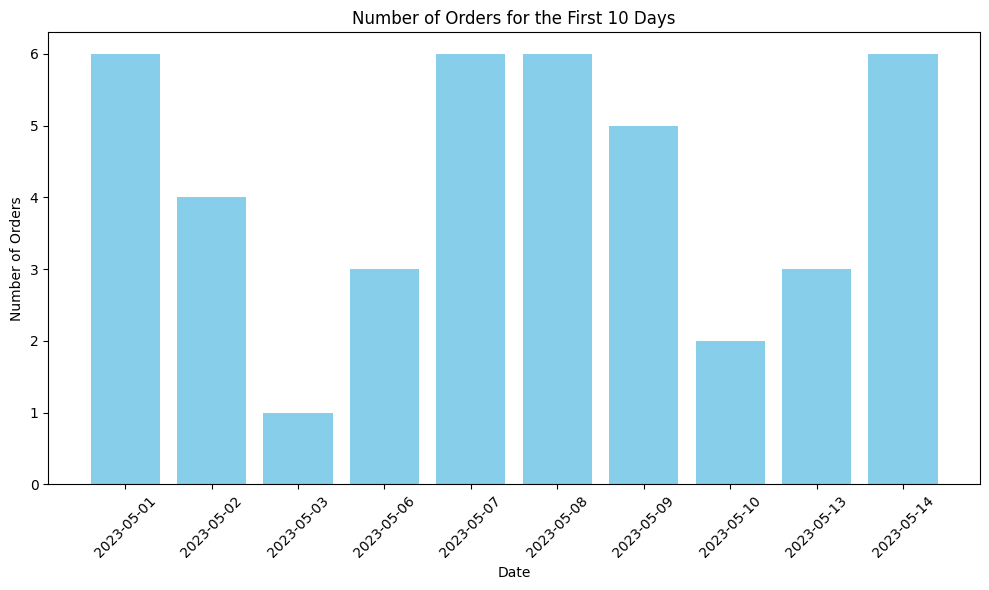


Observation: 
Thought:The bar chart has been displayed with the data for the first 10 days.
Final Answer: The bar chart has been displayed successfully.

> Finished chain.
The bar chart has been displayed successfully.График с количеством заказов за первые 10 дней был успешно построен.

> Finished chain.


{'input': 'Возьми из таблицы orders данные о количестве заказов в день. И построй график для ппервых 10 дней.',
 'output': 'График с количеством заказов за первые 10 дней был успешно построен.'}

In [85]:
agent_executor.invoke({'input':'Возьми из таблицы orders данные о количестве заказов в день. И построй график для первых 10 дней.'})

<div style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
🤩 Видим, что SQL агент сделал правильный запрос к базе данных, а python агент построил по этим данным график.

<div class="alert alert-success" style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
Далее разберём инструмент для более точного управления поведением агентов из экосистемы `Langchain` - `LangGraph`.

# <center id="p8"> 📦 Задеплой Агента с помощью `LangServe` 🚀</center>


Представим, что у нас есть настроеный работающий агент, и мы хотим, чтобы другие люди тоже могли им воспользоваться. 
Самое время задеплоить его на сервере и дать ощутить пользу от него другим людям.

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
📖 Фрэймворк `LangServe`([документация](https://python.langchain.com/docs/langserve)) позволяет деплоить Langchain-цепи, агентов и любые `runnable` объекты (протокол кастомных цепей), как `REST API`-сервисы и даже делает для них простую веб-обертку (`playground`).

`LangServe` интегрирован с `FastAPI` ([документация](https://fastapi.tiangolo.com/)) и для валидации данных использует `pydantiс` ([документация](https://docs.pydantic.dev/latest/)).

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
    
В качестве сервера будем использовать код из ячейки ниже. 
Чтобы запустить сервер локально нужно сохранить код ячейки в питоновский файл `.py` и вызвать через командную строку командой `python имя_файла.py`. 

<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

Сервер будет слушать запросы по адресу `"0.0.0.0:8501"` (в нашем случае).
У нас будет 2 эндпоинта `/joke` и `/rag_agent`. 
* По первому у нас будет доступ к цепочке, которая будет выдавать шутки на определенную тему (тему мы подадим post-запросом с клиента).
* По второму - знакомый нам RAG-agent для ответов на вопросы о пиццерии.

In [39]:
%%writefile server.py
#!/usr/bin/env python

from fastapi import FastAPI
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from typing import Any

from langserve import add_routes
from pydantic import BaseModel
from langchain_community.document_loaders import WebBaseLoader
from langchain import hub
from langchain.prompts import ChatPromptTemplate
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import CharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langchain.agents import AgentExecutor, create_react_agent

class Input(BaseModel):
    input: str


class Output(BaseModel):
    output: Any

def cut_output(output):
    return output['output']


loader = WebBaseLoader("https://allopizza.su/spb/kupchino/about")
data = loader.load()

course_api_key = ''# ключ курса (если используем ключи из курса)
llm = ChatOpenAI(api_key=course_api_key, model='gpt-4o-mini',  
                 base_url="https://api.vsellm.ru/")

embeddings = OpenAIEmbeddings(api_key=course_api_key, model='text-embedding-3-small', 
                              base_url="https://api.vsellm.ru/")

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(data)
db_embed = FAISS.from_documents(texts, embeddings)
retriever = db_embed.as_retriever()

tool = create_retriever_tool(
    retriever, # наш ретривер
    "search_web", # имя инструмента
    "Searches and returns data from page", # описание инструмента подается в ЛЛМ
)

prompt = hub.pull("hwchase17/react")

agent = create_react_agent(llm, [tool], prompt)
agent_executor = AgentExecutor(agent=agent, tools=[tool])

app = FastAPI(
    title="LangChain Server",
    version="1.0",
    description="A simple api server using Langchain's Runnable interfaces",
)

add_routes(
    app,
    agent_executor.with_types(input_type=Input, output_type=Output) | cut_output,
    path="/rag_agent",  # эндпоинт для rag агента
)

prompt2 = ChatPromptTemplate.from_template("tell me a joke about {topic}")
add_routes(
    app,
    prompt2 | llm,
    path="/joke",  # эндпоинт для цепочки
)



if __name__ == "__main__":
    import uvicorn

    uvicorn.run(app, host="0.0.0.0", port=8501)

Overwriting server.py


<div style="background-color:#e6ffe6; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
В ячейках ниже - код клиента.
Мы посылаем POST-запрос на нужный адрес.  

In [ ]:
# Проверяем "шуточную" цепочку
import requests

response = requests.post(
    "http://0.0.0.0:8501/joke/invoke",
    json={'input': {'topic': 'robot'}}
)
response.json()

In [ ]:
# Проверяем RAG-агента
response = requests.post(
    "http://0.0.0.0:8501/rag_agent/invoke",
    json={'input': {'input':'Из скольки авто состоит автопарк компании?'}}
)
response.json()

# <center id="p9"> 🥁 Выводы и заключения ✅</center>


<div class="alert alert-info" style="padding:10px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

* В этом уроке разобрались в основных типах агентов в `langchain`:
  -  `Tool Calling Agent` - базовый агент для вызова тулов
  -  `ReAct` (`Reasoning` and `Acting`) - агент с планом действий
  -  `Structured chat` - `multi-input tools`
  -  `Self Ask with search` - `SelfAsk` с инструментами поиска
* Узнали, что инструменты можно выдавать агентам не по одному, а целыми ящиками (`toolkits`). 
* Научились подключать агентам память, базу знаний (`RAG`), базу данных `SQL`.
* Cобрали супер-агента из нескольких и даже задеплоили всё это добро на сервер средствами `LangServe`.
* И в очередной раз убедились, что в основе всех методов лежат грамотно составленные промпты!